In [1]:
import numpy as np
from scipy import stats 
from scipy.stats import norm
from scipy import integrate
from functools import partial
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.linalg as la
from   scipy.special import gamma
from functools import partial
from functools import lru_cache

In [2]:
class Gaussian:
    def __init__(self, rho, Law_RS, Law_RF):
        self.rho = rho         # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        self.meta_Gaussian = stats.multivariate_normal([0,0], # Mean
                                                       [[1,rho], # COV
                                                        [rho,1]])

    def H(self, w, h, r_h): # a helper function to compute the input to F_RF
        A = self.Law_RS.ppf(w) - r_h
        if h!=0:
            B = h
        else:
            B = 0.00001
        return A/B
    
    def g(self, w, h, r_h):
        return self.Law_RF.cdf(self.H(w=w, h=h, r_h=r_h))
    
    def D1C(self, w, h, r_h):
        integrand = lambda u: self.meta_Gaussian.pdf([norm.ppf(w), u]) 
        part2 = 1/norm.pdf(norm.ppf(w))
        return integrate.quad(integrand, -np.infty, norm.ppf(self.g(w, h, r_h)))[0] * part2
    
    def F_RH(self, h, r_h):
        func = partial(self.D1C, h=h, r_h=r_h)
        I = integrate.quad(func, 0.0001, 0.999)
        return 1 - I[0]
    
    def c(self, u, v): # copula density
        part1 = self.meta_Gaussian.pdf([norm.ppf(u), norm.ppf(v)])
        part2 = norm.pdf(norm.ppf(u))* norm.pdf(norm.ppf(v))
        return part1/part2
    
    def f_RH(self, h, r_h):
        part1 = lambda u: self.c(u, self.g(w=u, h=h, r_h=r_h))
        part2 = lambda u: self.Law_RF.pdf(self.H(w=u, h=h, r_h=r_h))
        integrand = lambda u: part1(u)*part2(u)
        return integrate.quad(integrand, 0.0001, 0.999)[0]/np.abs(h)
        
    def sample(self, n):
        copula_samples = self.meta_Gaussian.rvs(n)
        samples = np.zeros((n,2))
        samples[:,0]=self.Law_RS.ppf(norm.cdf(copula_samples[:,0]))
        samples[:,1]=self.Law_RF.ppf(norm.cdf(copula_samples[:,1]))
        return samples

In [3]:
Law_RS = norm(loc=0, scale=1)
Law_RF = norm(loc=1, scale=1)

c = Gaussian(rho = 0.7,
               Law_RS = Law_RS,
               Law_RF = Law_RF)

In [4]:
r_h = np.linspace(-4,4,100)
density = []
for x in tqdm(r_h):
    density.append(c.f_RH(h=2, r_h=x))

  1%|          | 1/100 [00:02<03:52,  2.34s/it]


KeyboardInterrupt: 

In [ ]:
results = c.sample(10000)
s = results[:,0] - 2*results[:,1]
# plt.plot(r_h*1.8, np.array(density)*7)
sns.distplot(s)
plt.plot(r_h, np.array(density))
plt.savefig("rh_Gaussian.png", transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


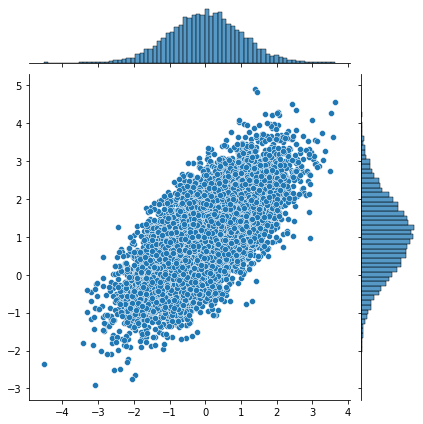

In [6]:
# sns.distplot(results[:,0] - results[:,1])
# plt.plot(r_h, np.array(density))
sns.jointplot(results[:,0], results[:,1], kind="scatter")
plt.savefig("rs_rf_Gaussian.png", transparent=True)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


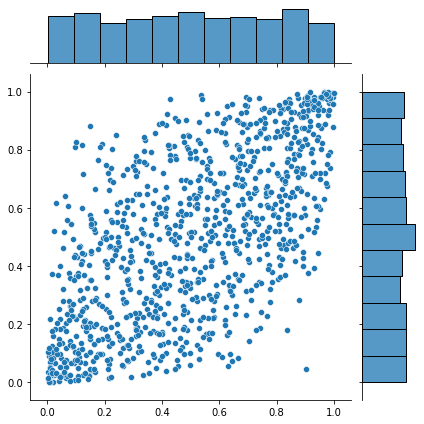

In [7]:
sns.jointplot(c.Law_RS.cdf(results[:1000,0]), 
              c.Law_RF.cdf(results[:1000,1]), kind="scatter")
plt.savefig("GaussianCopula_Samples.png", transparent=True)

In [8]:
r_h = np.linspace(-4,4,100)
cdf = []
for x in tqdm(r_h):
    cdf.append(c.F_RH(h=2, r_h=x))

  7%|▋         | 7/100 [00:54<12:17,  7.93s/it]

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (100,) and (7,)

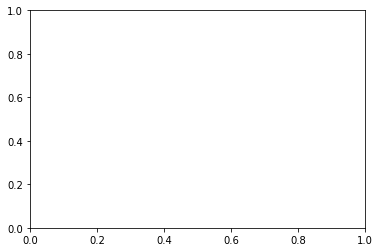

In [9]:
s = results[:,0] - 2*results[:,1]
ecdf = ECDF(s)
plt.plot(r_h, np.array(cdf))
plt.plot(sorted(s), ecdf(sorted(s)))

In [24]:
# Sampling for multivariate t
nu_meta = 2.1 # DF
# W_law = stats.invgamma(0.5*nu_meta, 0.5*nu_meta)
Z_law = stats.multivariate_normal([0,0], # Mean
           [[1,0], # COV
           [0,1]])

rho=-0.75
Sigma = [[1,rho], [rho,1]]
A = la.cholesky(Sigma, lower=True)

size = 2000
# W = W_law.rvs(size)
W = nu_meta/stats.chi2(nu_meta).rvs(size)
Z = Z_law.rvs(size)
X = (A.dot(Z.T))
X[0] = X[0]*np.sqrt(W)
X[1] = X[1]*np.sqrt(W)

nu_inner = 4
loc=0
scale=1
inner_t = stats.t(df=nu_inner, loc=loc, scale=scale)

In [25]:
factor = nu_meta/(nu_meta-2)
Sigma2 = np.array([[1,rho], # COV
         [rho,1]])*(1/factor)

Y = stats.multivariate_normal([0,0], # Mean
                          Sigma2).rvs(size)

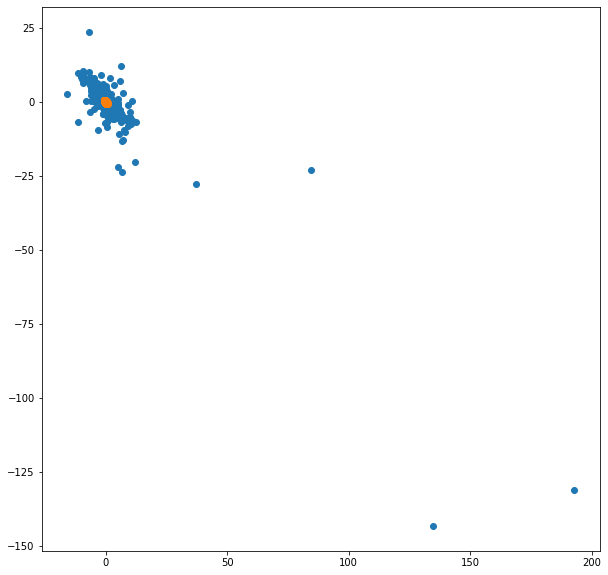

In [26]:
plt.figure(figsize=(10,10))
plt.scatter(X[0], X[1])
plt.scatter(Y[:,0], Y[:,1])

Text(0, 0.5, '$F_{X_2}(X_2)$')

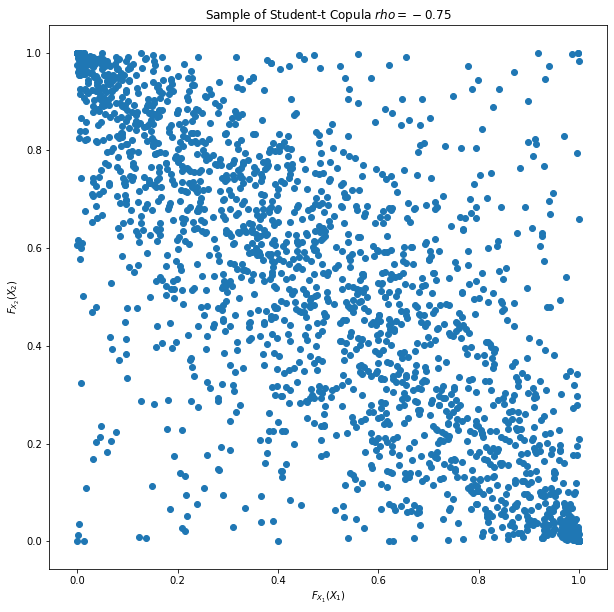

In [27]:
plt.figure(figsize=(10,10))

plt.scatter(inner_t.cdf(X[0]), 
              inner_t.cdf(X[1]))
plt.title(r"Sample of Student-t Copula $rho=%.2f$"%rho)
plt.xlabel(r"$F_{X_1}(X_1)$")
plt.ylabel(r"$F_{X_2}(X_2)$")

## Multivariate t Distribution
Scipy does not support multivariate t-distribution, so we need to code it.
Density of student t distribution
$$f_{\tilde{\nu},\Sigma, d}(x)=\frac{\Gamma\left(\frac{\tilde{\nu}+d}{2}\right)}
{\Gamma\left(\frac{\tilde{\nu}}{2}\right)\sqrt{(\pi\tilde{\nu})^d|\Sigma|}}
\left(
1+\frac{x^\top\Sigma^{-1}x}{\tilde{\nu}}
\right)^{-\frac{\tilde{\nu}+d}{2}}
$$

$$C_{\tilde{\nu}, \Sigma}^t(u)
=\int_{-\infty}^{t_\nu^{-1}(u_1)} ...  \int_{-\infty}^{t_\nu^{-1}(u_d)} 
f_{\tilde{\nu},\Sigma, d}(x)
dx
$$

We are interested in two-dimensional case
$$C_{\tilde{\nu}, \Sigma}^t(u)
=\int_{-\infty}^{t_\nu^{-1}(u_1)}  \int_{-\infty}^{t_\nu^{-1}(u_2)} 
\frac{\Gamma\left(\frac{\tilde{\nu}+2}{2}\right)}
{\Gamma\left(\frac{\tilde{\nu}}{2}\right)\sqrt{(\pi\tilde{\nu})^2|\Sigma|}}
\left(
1+\frac{x^\top\Sigma^{-1}x}{\tilde{\nu}}
\right)^{-\frac{\tilde{\nu}+2}{2}}
dx
$$

In [5]:
class multivariate_t:
    def __init__(self, nu, Sigma):
        self.nu = nu
        self.Sigma = Sigma
        self.d = self.Sigma.shape[0] 
        if self.d !=  Sigma.shape[1]:
            return print("Sigma must be a square matrix")
        
    def pdf(self, *argv):
        # mean = \vec{0}
        x = np.array([i for i in argv])

        if len(x) != self.d:
            return print("Dimension not correct")

        try:
            s = la.inv(self.Sigma)[0,1]
        except:
            print("Sigma is not invertable")

        part1 = gamma((self.nu+self.d)/2)
        part2 = gamma(self.nu/2)*np.sqrt(((np.pi*self.nu)**self.d)*la.det(self.Sigma))
        part3 = (1 + (x.dot(la.inv(self.Sigma)).dot(x))/self.nu)**(-(self.nu+self.d)/2)
        return (part1/part2)*part3

    def cdf(self, upper):
        uppers = [[-np.infty, upper[i]] for i in range(len(upper))]
        fn = partial(self.pdf)
        return integrate.nquad(fn, uppers)[0]

    def rvs(self, size): # Sample 
        Z_law = stats.multivariate_normal(np.zeros(self.d), # Mean
           np.eye(self.d))

        A = la.cholesky(self.Sigma, lower=True)
        W = self.nu/stats.chi2(self.nu).rvs(size)
        Z = Z_law.rvs(size)
        X = (A.dot(Z.T))
        sqrt_W = np.sqrt(W)
        for i in range(self.d):
            X[i] = X[i]*sqrt_W
        return X.T

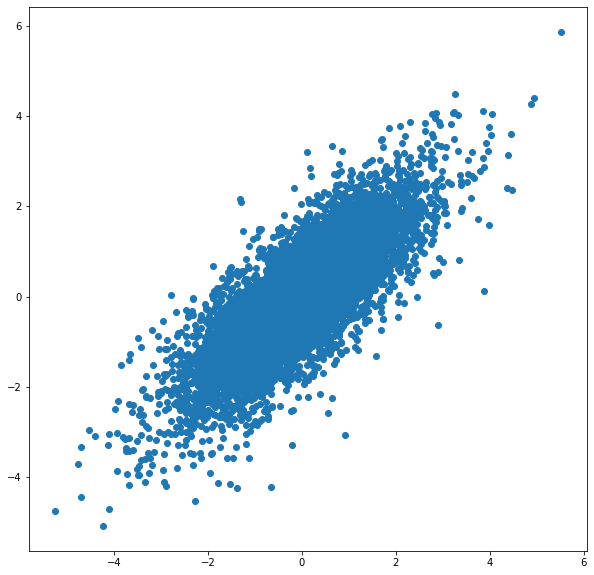

In [6]:
Sigma = np.array([[1,0.8], [0.8,1]])
meta_t = multivariate_t(nu=10, Sigma=Sigma)
results = meta_t.rvs(10000)
plt.figure(figsize=(10,10))
plt.scatter(results[:,0], results[:,1])

In [4]:
i=25
meta_t.cdf([i, 0])

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  **opt)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:860: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  **opt)


0.49149374441911303

In [7]:
results[0] <= i

array([ True,  True])

In [8]:
np.mean((results[:,0] <= i) & (results[:,1] <= 0))

0.5062

In [7]:
class t_Copula:
    def __init__(self, rho, nu_meta, nu_inner_1, nu_inner_2, Law_RS, Law_RF):
        self.rho = rho         # Dependence Parameter
        self.Law_RS = Law_RS   # Marginal Distribution of Spot
        self.Law_RF = Law_RF   # Marginal Distribution of Future
        self.meta_t = multivariate_t(nu   =nu_meta,  # DF
                                     Sigma=np.array([[1,rho], # COV
                                            [rho,1]]))
        self.t1 = stats.t(df=nu_inner_1) # inner
        self.t2 = stats.t(df=nu_inner_2) # inner

    def H(self, w, h, r_h): # a helper function to compute the input to F_RF
        A = self.Law_RS.ppf(w) - r_h
        if h!=0:
            B = h
        else:
            B = 0.00001
        return A/B
    
    def g(self, w, h, r_h):
        return self.Law_RF.cdf(self.H(w=w, h=h, r_h=r_h))
    
    def D1C(self, w, h, r_h):
        integrand = lambda u: self.meta_t.pdf(self.t.ppf(w), u) 
        part2 = 1/self.t1.pdf(self.t.ppf(w))
        return integrate.quad(integrand, -np.infty, self.t2.ppf(self.g(w, h, r_h)))[0] * part2
    
    def F_RH(self, h, r_h):
        func = partial(self.D1C, h=h, r_h=r_h)
        I = integrate.quad(func, 0.0001, 0.999)
        return 1 - I[0]
    
    def c(self, u, v): # copula density
        part1 = self.meta_t.pdf(self.t1.ppf(u), self.t2.ppf(v))
        part2 = self.t1.pdf(self.t1.ppf(u))* self.t2.pdf(self.t2.ppf(v))
        return part1/part2
    
    def f_RH(self, h, r_h):
        part1 = lambda u: self.c(u, self.g(w=u, h=h, r_h=r_h))
        part2 = lambda u: self.Law_RF.pdf(self.H(w=u, h=h, r_h=r_h))
        integrand = lambda u: part1(u)*part2(u)
        return integrate.quad(integrand, 0.0001, 0.999)[0]/np.abs(h)
        
    def sample(self, n):
        copula_samples = self.meta_t.rvs(n)
        samples = np.zeros((n,2))
        samples[:,0]=self.Law_RS.ppf(self.t1.cdf(copula_samples[:,0]))
        samples[:,1]=self.Law_RF.ppf(self.t2.cdf(copula_samples[:,1]))
        return samples

In [71]:
id0 = (results[:,1] <= (0+0.00002))
id1 = (results[:,1] >= (0-0.00002))
ids = id0 & id1
np.mean(ids)
np.mean(results[ids,0] <=0)

nan

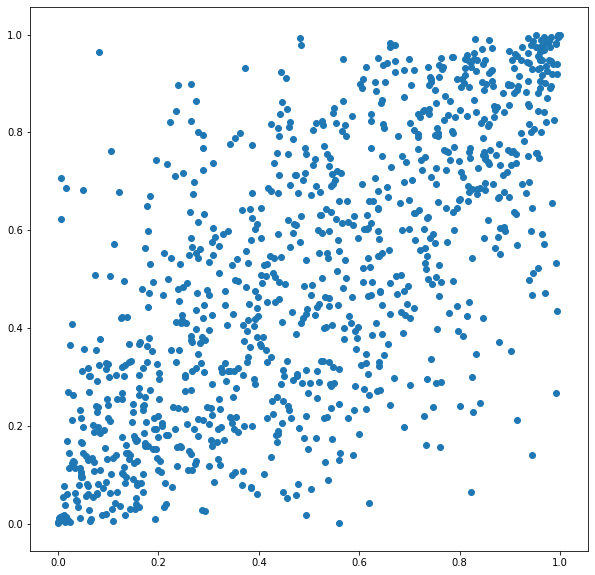

In [21]:
c = t_Copula(rho        = 0.7, 
             nu_meta    = 6,
             nu_inner_1 = 6,
             nu_inner_2 = 6,
             Law_RS     = stats.norm,
             Law_RF     = stats.norm)

s = c.sample(1000)
plt.figure(figsize=(10,10))
plt.scatter(c.Law_RS.cdf(s[:,0]), c.Law_RF.cdf(s[:,1]))
# plt.scatter(s[:,0], s[:,1])

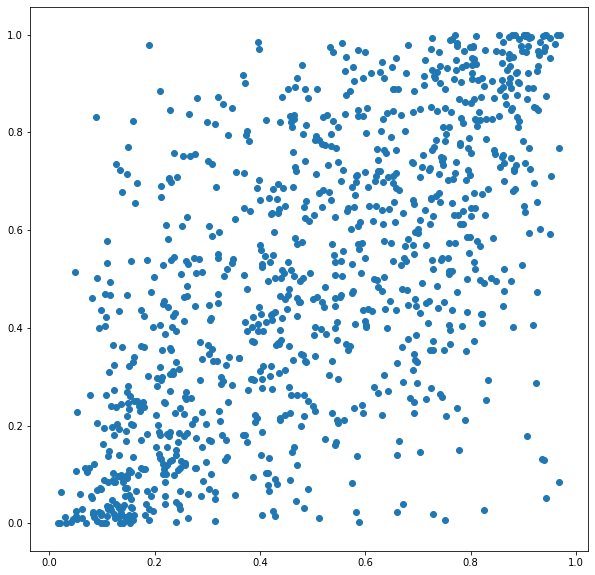

In [87]:
s = c.sample(1000)
plt.figure(figsize=(10,10))
plt.scatter(c.Law_RS.cdf(s[:,0]), c.Law_RF.cdf(s[:,1]))
# plt.scatter(s[:,0], s[:,1])

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


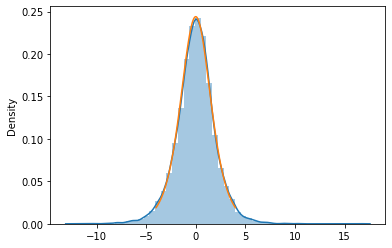

In [88]:
r_h = np.linspace(-4,4,100)
density = []
for x in tqdm(r_h):
    density.append(c.f_RH(h=2, r_h=x))

results = c.sample(10000)
s = results[:,0] - 2*results[:,1]
# plt.plot(r_h*1.8, np.array(density)*7)
sns.distplot(s)
plt.plot(r_h, np.array(density))
plt.savefig("rh_Gaussian.png", transparent=True)

In [ ]:
# support of Law_RS and Law_RF solution: 